# Terms Aggregation e WordCloud

In [20]:
import json
import wordcloud
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import elasticsearch

ES_URL = 'https://localhost:9200'
ES_USER = 'elastic'
ES_PASS = 'elastic123'

client = elasticsearch.Elasticsearch(
    ES_URL,
    basic_auth=(ES_USER, ES_PASS),
    verify_certs=False
)

/home/felipefg/.pyenv/versions/3.9.1/envs/infnet/lib/python3.9/site-packages/elasticsearch/_sync/client/__init__.py:395: SecurityWarning: Connecting to 'https://localhost:9200' using TLS with verify_certs=False is insecure
  _transport = transport_class(


In [4]:
# Desligando warning para facilitar nossa vida
import urllib3
urllib3.disable_warnings()

In [5]:
INDEX_NAME = '20newsgroup_teste_insercao'

In [6]:
client.info()

ObjectApiResponse({'name': 'es01', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'lAp3li4KRDO3fTSHji4B4g', 'version': {'number': '8.2.2', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '9876968ef3c745186b94fdabd4483e01499224ef', 'build_date': '2022-05-25T15:47:06.259735307Z', 'build_snapshot': False, 'lucene_version': '9.1.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

# Terms Aggregation sobre campo Keyword

In [7]:
QUERY = {
    'match_all': {}
}

AGG = {
    'grupos': {
        'terms': {
            'field': 'newsgroup.raw',
            'size': 20,
        }
    }
}

In [8]:
resp = client.search(index=INDEX_NAME, query=QUERY, aggregations=AGG, size=0)

In [9]:
resp['hits']

{'total': {'value': 10000, 'relation': 'gte'}, 'max_score': None, 'hits': []}

In [10]:
resp['aggregations']

{'grupos': {'doc_count_error_upper_bound': 0,
  'sum_other_doc_count': 0,
  'buckets': [{'key': 'rec.sport.hockey', 'doc_count': 600},
   {'key': 'soc.religion.christian', 'doc_count': 599},
   {'key': 'rec.motorcycles', 'doc_count': 598},
   {'key': 'rec.sport.baseball', 'doc_count': 597},
   {'key': 'sci.crypt', 'doc_count': 595},
   {'key': 'rec.autos', 'doc_count': 594},
   {'key': 'sci.med', 'doc_count': 594},
   {'key': 'comp.windows.x', 'doc_count': 593},
   {'key': 'sci.space', 'doc_count': 593},
   {'key': 'comp.os.ms-windows.misc', 'doc_count': 591},
   {'key': 'sci.electronics', 'doc_count': 591},
   {'key': 'comp.sys.ibm.pc.hardware', 'doc_count': 590},
   {'key': 'misc.forsale', 'doc_count': 585},
   {'key': 'comp.graphics', 'doc_count': 584},
   {'key': 'comp.sys.mac.hardware', 'doc_count': 578},
   {'key': 'talk.politics.mideast', 'doc_count': 564},
   {'key': 'talk.politics.guns', 'doc_count': 546},
   {'key': 'alt.atheism', 'doc_count': 480},
   {'key': 'talk.politics.

In [11]:
df_newsgroup_agg = pd.DataFrame(resp['aggregations']['grupos']['buckets'])

In [12]:
df_newsgroup_agg

,key,doc_count
0,rec.sport.hockey,600
1,soc.religion.christian,599
2,rec.motorcycles,598
3,rec.sport.baseball,597
4,sci.crypt,595
5,rec.autos,594
6,sci.med,594
7,comp.windows.x,593
8,sci.space,593
9,comp.os.ms-windows.misc,591


<AxesSubplot:xlabel='key'>

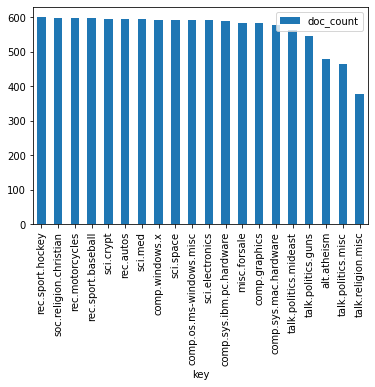

In [13]:
df_newsgroup_agg.plot(x='key', kind='bar')

# Wordcloud sobre campo analizado

In [14]:
QUERY = {
    'match_all': {}
}

AGG = {
    'mensagem': {
        'terms': {
            'field': 'message',
            'size': 100,
        }
    }
}

In [15]:
resp = client.search(index=INDEX_NAME, query=QUERY, aggregations=AGG, size=0)

In [16]:
frequencies = {}

buckets = resp['aggregations']['mensagem']['buckets']

for bucket in buckets:
    frequencies[bucket['key']] = bucket['doc_count']

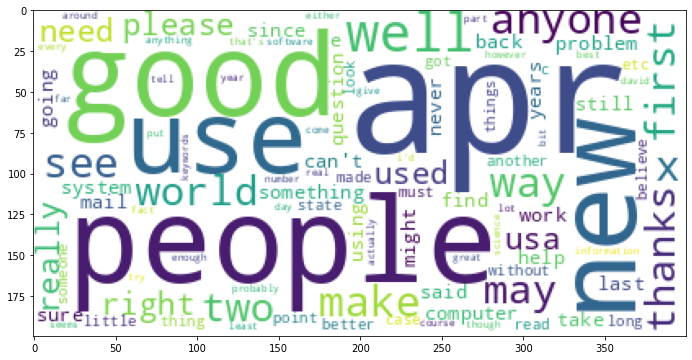

In [17]:
cloud = wordcloud.WordCloud(background_color='white')
cloud.generate_from_frequencies(frequencies)

fig, ax = plt.subplots(figsize=(16, 6))
ax.imshow(cloud)

# Wordcloud para grupo rec.sport.hockey

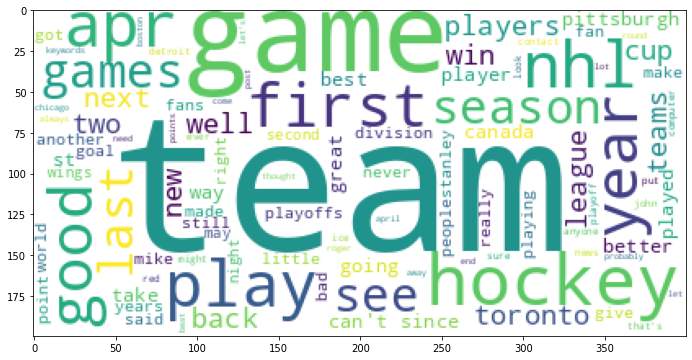

In [18]:
QUERY = {
    'term': {
        'newsgroup.raw': 'rec.sport.hockey'
    }
}

AGG = {
    'mensagem': {
        'terms': {
            'field': 'message',
            'size': 100,
        }
    }
}

resp = client.search(index=INDEX_NAME, query=QUERY, aggregations=AGG, size=0)

frequencies = {}

buckets = resp['aggregations']['mensagem']['buckets']

for bucket in buckets:
    frequencies[bucket['key']] = bucket['doc_count']

cloud = wordcloud.WordCloud(background_color='white')
cloud.generate_from_frequencies(frequencies)

fig, ax = plt.subplots(figsize=(16, 6))
ax.imshow(cloud)

# Wordcloud e Grupos que casem com o termo 'windows'

Text(0.5, 1.0, 'Significant Terms')

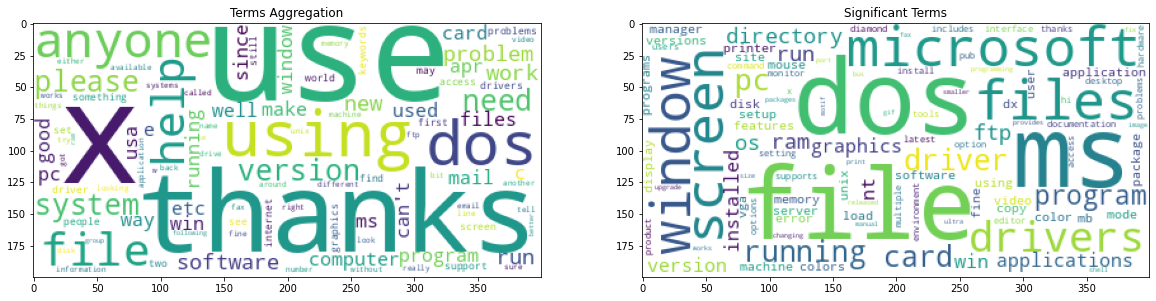

In [35]:
#QUERY = {
#    'term': {
#        'newsgroup.raw': 'sci.electronics'
#    }
#}

QUERY = {
    'term': {
        'message': 'windows'
    }
}

AGG = {
    'mensagem': {
        'terms': {
            'field': 'message',
            'size': 100,
            'exclude': '(windows)',
        }
    },
    'significativos': {
        'significant_terms': {
            'field': 'message',
            'size': 100,
            'exclude': '(windows)',
             "gnd": {
                 
             }
        }
    },
    'grupos': {
        'terms': {
            'field': 'newsgroup.raw',
            'size': 20,
        }
    }
}

resp = client.search(index=INDEX_NAME, query=QUERY, aggregations=AGG, size=0)

frequencies = {}

buckets = resp['aggregations']['mensagem']['buckets']

for bucket in buckets:
    frequencies[bucket['key']] = bucket['doc_count']

cloud = wordcloud.WordCloud(background_color='white')
cloud.generate_from_frequencies(frequencies)

frequencies_sig = {}
buckets_sig = resp['aggregations']['significativos']['buckets']

for bucket in buckets_sig:
    frequencies_sig[bucket['key']] = bucket['score']

cloud_sig = wordcloud.WordCloud(background_color='white')
cloud_sig.generate_from_frequencies(frequencies_sig)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
ax1.imshow(cloud)
ax1.set_title('Terms Aggregation')

ax2.imshow(cloud_sig)
ax2.set_title('Significant Terms')

In [36]:
resp['aggregations']['significativos']

{'doc_count': 766,
 'bg_count': 11314,
 'buckets': [{'key': 'dos',
   'doc_count': 226,
   'score': 0.6938626092769928,
   'bg_count': 401},
  {'key': 'ms',
   'doc_count': 151,
   'score': 0.6346685420752611,
   'bg_count': 318},
  {'key': 'file',
   'doc_count': 181,
   'score': 0.6205819060675061,
   'bg_count': 550},
  {'key': 'microsoft',
   'doc_count': 86,
   'score': 0.6039427148946026,
   'bg_count': 148},
  {'key': 'files',
   'doc_count': 144,
   'score': 0.6022385983211089,
   'bg_count': 419},
  {'key': 'window',
   'doc_count': 131,
   'score': 0.5947732116335048,
   'bg_count': 378},
  {'key': 'screen',
   'doc_count': 108,
   'score': 0.5870363059990772,
   'bg_count': 286},
  {'key': 'drivers',
   'doc_count': 101,
   'score': 0.5851561490721184,
   'bg_count': 258},
  {'key': 'running',
   'doc_count': 147,
   'score': 0.5778018164663243,
   'bg_count': 558},
  {'key': 'driver',
   'doc_count': 103,
   'score': 0.5727661917265398,
   'bg_count': 309},
  {'key': 'pc', 